In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Data Wrangling
# -----------------
def converttemp(x):
    """Convert Celsius to Fahrenheit"""
    return (x * 1.8) + 32

def wrangle(df):
    df = df.copy()
    # Convert to Fahrenheit
    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)

    # Convert dt column to datetime
    df["dt"] = pd.to_datetime(df["dt"])
    df["Year"] = df["dt"].dt.year

    # Drop unnecessary columns
    df = df.drop(columns=["dt"], axis=1)

    # Keep only data from 1850 onwards
    df = df[df["Year"] >= 1850]

    # Set Year as index
    df = df.set_index("Year")

    # Drop missing values
    df = df.dropna()

    return df



In [3]:
# Load and Prep Data
# -----------------
global_temp = pd.read_csv("GlobalTemperatures.csv")
global_temp = wrangle(global_temp)

print(global_temp.head())

      LandAverageTemperature  LandAverageTemperatureUncertainty  \
Year                                                              
1850                 33.3482                              1.105   
1850                 37.5278                              1.275   
1850                 40.9172                              0.955   
1850                 44.9906                              0.665   
1850                 50.0072                              0.617   

      LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
Year                                                                          
1850             46.8356                          1.738             26.2292   
1850             49.9460                          3.007             27.8762   
1850             50.6246                          2.401             28.5710   
1850             55.2812                          1.004             33.8324   
1850             60.1790                          2.406 

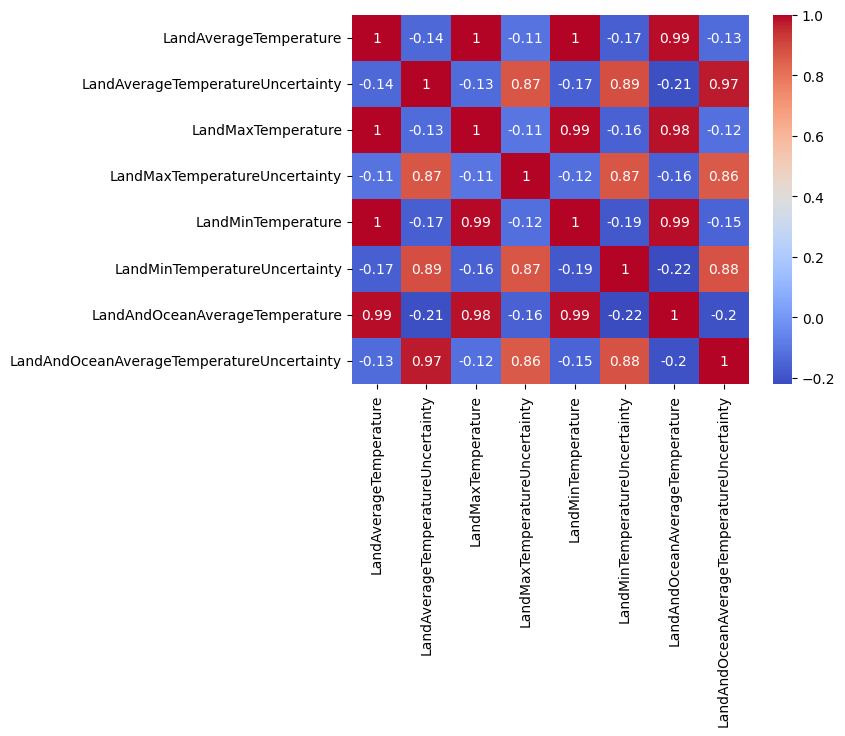

Train shape: (1494, 3)
Val shape: (498, 3)


In [4]:
# Correlation heatmap
corrMatrix = global_temp.corr()
sns.heatmap(corrMatrix, annot=True, cmap="coolwarm")
plt.show()

# -----------------
# Features & Target
# -----------------
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
X = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.25, random_state=42)

print("Train shape:", xtrain.shape)
print("Val shape:", xval.shape)

In [5]:
# Baseline
# -----------------
baseline_pred = [ytrain.mean()] * len(yval)
baseline_mae = mean_absolute_error(yval, baseline_pred)
print("Baseline MAE:", round(baseline_mae, 5))

# -----------------
# Random Forest Model
# -----------------
forest = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)

forest.fit(xtrain, ytrain)
ypred = forest.predict(xval)


Baseline MAE: 2.01986


In [6]:
# Evaluation
mae = mean_absolute_error(yval, ypred)
mse = mean_squared_error(yval, ypred)
rmse = np.sqrt(mse)

mape = 100 * np.mean(np.abs((yval - ypred) / yval))
accuracy = 100 - mape

print("Random Forest MAE:", round(mae, 5))
print("Random Forest RMSE:", round(rmse, 5))
print("Random Forest Accuracy:", round(accuracy, 2), "%")

Random Forest MAE: 0.2443
Random Forest RMSE: 0.31866
Random Forest Accuracy: 99.59 %
